# Using YOLO in Darkflow to detect birds from images
---
*Last Updated 19 November 2019*   
OS: Windows 10  
GPU: NVIDIA GeForce GTX 970M  
Requirements: Before running, need to install Visual Studio 2015 with Windows SDK, CUDA 10.0, cuDNN 7.6.0   
Tensorflow-gpu version 1.15rc

## Start in the command prompt
---
Code only listed here as an example. These commands needs to be run in the command prompt window.

In [ ]:
# in your chosen working directory, make a new folder 'yolo_imgdetect/'
mkdir yolo_imgdetect
cd yolo_imgdetect

In [ ]:
# make sure you are using Python 3.6
# install packages using pip
python --version
pip install tensorflow-gpu==1.15.0rc2
pip install cython
pip install opencv-python

In [ ]:
# download and compile darknet (the underlying framework of YOLO)
git clone https://github.com/pjreddie/darknet
cd darknet
python setup.py build_ext --inplace

In [ ]:
# install darkflow, the tensorflow implementation of darknet
git clone https://github.com/thtrieu/darkflow.git
pip install .

### Download the pre-trained object detection weight files
---   
The models are already in darkflow/cfg, but the weights associated with these models need to be downloaded from https://pjreddie.com/media/files/yolov3.weights and https://drive.google.com/drive/folders/0B1tW_VtY7onidEwyQ2FtQVplWEU. After downloading, move them to yolo_imgdetect/bin 

In [ ]:
# test installation, you should see an output with different parameters for flow
python flow --h

In [ ]:
# open Jupyter Notebook in the current working directory
jupyter notebook

## Here in Jupyter Notebook
---   
This is where you will run the images through the object detection model and you will be able to see the outputs as labelled images with detection classes and confidence scores within this browser window below.

In [2]:
import cv2
from darkflow.net.build import TFNet
import matplotlib.pyplot as plt
import pathlib
import time
import numpy as np
import csv
import os

%config InlineBackend.figure_format = 'svg'

### "Flow" the images through the model
---   
Ignore the warning messages about deprecated names, they still work at the time this last updated. Code for parameters is based on https://github.com/thtrieu/darkflow ("Using darkflow from another python application").

Your output should be a table of values like those shown below:

Source | Train? | Layer description                | Output size
------- |:--------:|:----------------------------------:| ---------------
       |        | input                            | (?, 448, 448, 3)
 Load  |  Yep!  | scale to (-1, 1)                 | (?, 448, 448, 3)
 Load  |  Yep!  | conv 3x3p1_1    leaky            | (?, 448, 448, 16)

In [3]:
# define parameters for "flow"ing the images through the model
params = {
    'model': 'cfg\yolo-tiny.cfg',
    'load': 'bin\yolo-tiny.weights',
    'threshold': 0.3,
    'gpu': 1.0
}

# run the model
tfnet = TFNet(params)

Parsing ./cfg/yolo-tiny.cfg
Parsing cfg\yolo-tiny.cfg
Loading bin\yolo-tiny.weights ...
Successfully identified 180357512 bytes
Finished in 0.009989261627197266s
Model has a VOC model name, loading VOC labels.

Building net ...

Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 448, 448, 3)
 Load  |  Yep!  | scale to (-1, 1)                 | (?, 448, 448, 3)
 Load  |  Yep!  | conv 3x3p1_1    leaky            | (?, 448, 448, 16)

 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 224, 224, 16)
 Load  |  Yep!  | conv 3x3p1_1    leaky            | (?, 224, 224, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 112, 112, 32)
 Load  |  Yep!  | conv 3x3p1_1    leaky            | (?, 112, 112, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 56, 56, 64)
 Load  |  Yep!  | conv 3x3p1_1    leaky            | (?, 56, 56, 128)
 Lo

### Set the path to the sample images
You can also delete the images from this folder and replace them with your own

In [5]:
# this is the image path 'yolo_imgdetect/sample_img'
PATH_TO_SAMPLE_IMAGES_DIR = pathlib.Path('sample_img')
SAMPLE_IMAGE_PATHS = sorted(list(PATH_TO_SAMPLE_IMAGES_DIR.glob("*.jpg")))
SAMPLE_IMAGE_PATHS

[WindowsPath('sample_img/542.10578857864.jpg'),
 WindowsPath('sample_img/542.15445377044.jpg'),
 WindowsPath('sample_img/542.4801468374.jpg'),
 WindowsPath('sample_img/542.7816025222.jpg')]

### Define function used to draw bounding boxes
You can adjust the parameters so that bounding boxes are only shown for certain confidence or class values.
Here boxes are shown when confidence > 0.3 and object class is 'bird'. This function is modified from here https://gist.github.com/deep-diver/40f092ad56525189674a86b6fde6d304.

In [6]:
def boxing(img, predictions):
    newImage = np.copy(img)
    im_height, im_width, im_depth = img.shape
        
    for result in predictions:
        xmin = result['topleft']['x']
        ymin = result['topleft']['y']

        xmax = result['bottomright']['x']
        ymax = result['bottomright']['y']

        confidence = result['confidence']
        label = result['label'] + " " + str(round(confidence, 3))

        # only show boxes that are above .3 confidence and for the label, bird
        if confidence > 0.3 and result['label'] == 'bird' :
            with open('sample_img/out/sample_crops_yolo.tsv', 'a') as out_file:
                tsv_writer = csv.writer(out_file, delimiter='\t')
                crop_width = xmax-xmin
                crop_height = ymax-ymin
                tsv_writer.writerow([os.path.splitext((os.path.basename(image_path)))[0], im_height, im_width, 
                            xmin, ymin, crop_height, crop_width])
            fontScale = min(im_width,im_height)/(600)
            newImage = cv2.rectangle(newImage, (xmin, ymax), (xmax, ymin), (255,0,0), 3)
            newImage = cv2.putText(newImage, label, (xmin, ymax-5), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0, 230, 0), 7, cv2.LINE_AA)
            
    return newImage

## Run detector for all sample images
---   
Run the image detector for all images within 'sample_img/'. Results are plotted below and include the image with bounding box, class type, and confidence score. Inference times are printed below images.

Inference time: 3.353081703186035
Inference time: 0.04087567329406738
Inference time: 0.0399327278137207
Inference time: 0.039917945861816406


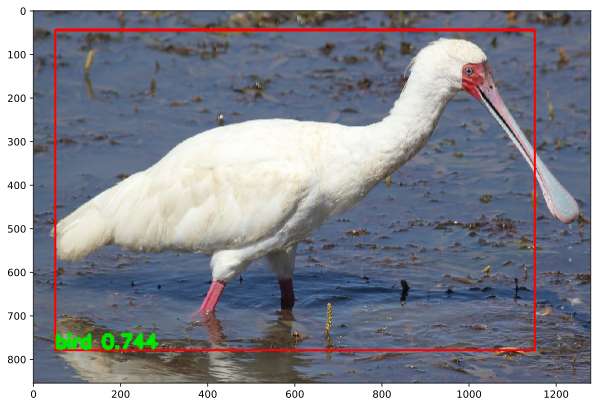

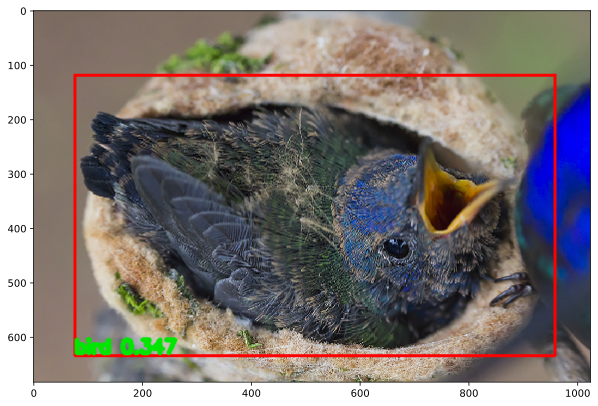

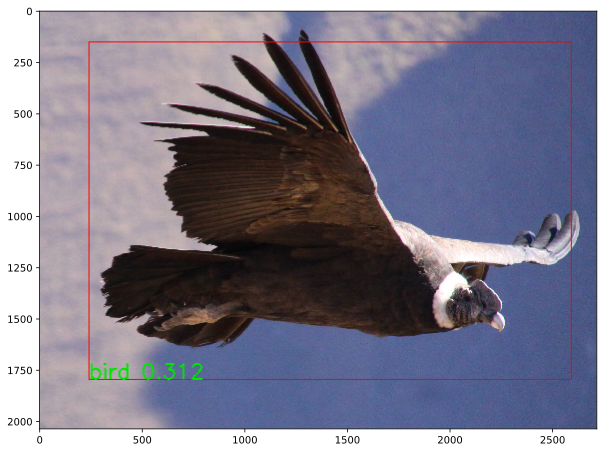

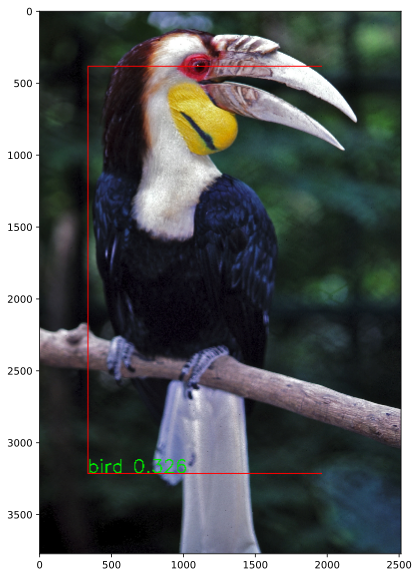

In [7]:
# loop through all images in 'sample_img/'
for image_path in SAMPLE_IMAGE_PATHS:
  img = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # use YOLO for object detection  
  # record inference time
  start_time = time.time()
  result = tfnet.return_predict(img)
  end_time = time.time()
  print("Inference time:", end_time-start_time)

  # plot and show detection boxes on images
  _, ax = plt.subplots(figsize=(10, 10))
  ax.imshow(boxing(img, result))